# 1 - Introduction

Nama : Geraldine D

Batch : FTDS-RMT-19

Dataset Overview : Rice, which is among the most widely produced grain products worldwide, has many genetic varieties. These varieties are separated from each other due to some of their features. These are usually features such as texture, shape, and color. With these features that distinguish rice varieties, it is possible to classify and evaluate the quality of seeds. In this study, Arborio, Basmati, Ipsala, Jasmine and Karacadag, which are five different varieties of rice often grown in Turkey, were used. A total of 75,000 grain images, 15,000 from each of these varieties, are included in the dataset. 

Objectives : to develop a Convolutional Neural Network (CNN) model capable of accurately classifying different varieties of rice based on their grain images. By leveraging the distinguishing features of rice varieties, such as texture, shape, and color, the CNN model aims to provide an automated and efficient method for rice variety classification.

[Rice Image Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset)

[Model Deployment](https://huggingface.co/spaces/andinedwrn/riceclass)

# 2 - Import Libraries

In [2]:
pip install pathlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
#Import Libraries
import os
import shutil
import random
import glob 

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import PIL
import pathlib
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.image as mpimg

#Modelling and Preprocessing
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

#Model Evaluation
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 3 - Data Loading

## 3.1 - Loading Image Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir ~/.kaggle

# !cp 'kaggle.json' ~/.kaggle
!cp '/content/drive/MyDrive/kagglejson/kaggle.json' ~/.kaggle

!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

 98% 216M/219M [00:10<00:00, 26.2MB/s]
100% 219M/219M [00:10<00:00, 21.3MB/s]


In [6]:
!unzip -q rice-image-dataset.zip -d images

In [7]:
# Checking Folder
os.listdir('/content/images/Rice_Image_Dataset' )

['Jasmine',
 'Karacadag',
 'Arborio',
 'Ipsala',
 'Basmati',
 'Rice_Citation_Request.txt']

## 3.2 - Splitting Data set into Train, Val and Test set

In [8]:
# Set the paths
base_folder = '/content/images/Rice_Image_Dataset'
output_folder = '/content/split_dataset'

# Create the output directories
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [9]:
# Define the ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [10]:
# Get the list of class folders
classes = [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder))]

# Iterate over each class folder
for class_name in classes:
    class_folder = os.path.join(base_folder, class_name)
    images = os.listdir(class_folder)
    random.shuffle(images)
    
    num_train = int(len(images) * train_ratio)
    num_val = int(len(images) * val_ratio)
    num_test = int(len(images) * test_ratio)
    
    # Copy images to the corresponding directories
    for i, image in enumerate(images):
        src = os.path.join(class_folder, image)
        
        if i < num_train:
            dst = os.path.join(train_dir, class_name, image)
        elif i < num_train + num_val:
            dst = os.path.join(val_dir, class_name, image)
        else:
            dst = os.path.join(test_dir, class_name, image)
        
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Dataset split completed successfully!")


Dataset split completed successfully!


to see the distribution data of splitted data set we need to check the number of sample in each set

In [11]:
# Checking train set
print("Train set:")
for class_name in os.listdir(train_dir):
    class_folder = os.path.join(train_dir, class_name)
    num_samples = len(os.listdir(class_folder))
    print(f"Class: {class_name}, Number of samples: {num_samples}")

Train set:
Class: Jasmine, Number of samples: 12000
Class: Karacadag, Number of samples: 12000
Class: Arborio, Number of samples: 12000
Class: Ipsala, Number of samples: 12000
Class: Basmati, Number of samples: 12000


In [12]:
# Checking validation set
print("Validation set:")
for class_name in os.listdir(val_dir):
    class_folder = os.path.join(val_dir, class_name)
    num_samples = len(os.listdir(class_folder))
    print(f"Class: {class_name}, Number of samples: {num_samples}")


Validation set:
Class: Jasmine, Number of samples: 1500
Class: Karacadag, Number of samples: 1500
Class: Arborio, Number of samples: 1500
Class: Ipsala, Number of samples: 1500
Class: Basmati, Number of samples: 1500


In [13]:
# Checking test set
print("Test set:")
for class_name in os.listdir(test_dir):
    class_folder = os.path.join(test_dir, class_name)
    num_samples = len(os.listdir(class_folder))
    print(f"Class: {class_name}, Number of samples: {num_samples}")

Test set:
Class: Jasmine, Number of samples: 1500
Class: Karacadag, Number of samples: 1500
Class: Arborio, Number of samples: 1500
Class: Ipsala, Number of samples: 1500
Class: Basmati, Number of samples: 1500


okay, all set lets moving on to the next step

In [14]:
train_basmati = glob.glob(os.path.join(train_dir, 'Basmati', '*.jpg'))
train_arborio = glob.glob(os.path.join(train_dir, 'Arborio', '*.jpg'))
train_karacadag = glob.glob(os.path.join(train_dir, 'Karacadag', '*.jpg'))
train_jasmine = glob.glob(os.path.join(train_dir, 'Jasmine', '*.jpg'))
train_ipsala = glob.glob(os.path.join(train_dir, 'Ipsala', '*.jpg'))

test_basmati = glob.glob(os.path.join(test_dir, 'Basmati', '*.jpg'))
test_arborio = glob.glob(os.path.join(test_dir, 'Arborio', '*.jpg'))
test_karacadag = glob.glob(os.path.join(test_dir, 'Karacadag', '*.jpg'))
test_jasmine = glob.glob(os.path.join(test_dir, 'Jasmine', '*.jpg'))
test_ipsala = glob.glob(os.path.join(test_dir, 'Ipsala', '*.jpg'))

val_basmati = glob.glob(os.path.join(val_dir, 'Basmati', '*.jpg'))
val_arborio = glob.glob(os.path.join(val_dir, 'Arborio', '*.jpg'))
val_karacadag = glob.glob(os.path.join(val_dir, 'Karacadag', '*.jpg'))
val_jasmine = glob.glob(os.path.join(val_dir, 'Jasmine', '*.jpg'))
val_ipsala = glob.glob(os.path.join(val_dir, 'Ipsala', '*.jpg'))

## 3.3 - Create Data Frame and shows data

here we create the data frame of each directory

In [15]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

# Create DataFrames for train, test, and validation sets
train_df = create_dataframe(train_basmati + train_arborio + train_karacadag + train_jasmine + train_ipsala)
test_df = create_dataframe(test_basmati + test_arborio + test_karacadag + test_jasmine + test_ipsala)
val_df = create_dataframe(val_basmati + val_arborio + val_karacadag + val_jasmine + val_ipsala)

# Shuffle the DataFrames
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=1).reset_index(drop=True)


we also need to spare some data for model inference so because we have plenty data, we will only use 1% data for data inference retrieved from the test set 

In [16]:
# using 10% of test set to inf set

test_df, inf_df = train_test_split(test_df, test_size=0.01, random_state=1, stratify = test_df['label'])
print(test_df.shape)
print(inf_df.shape)

(7425, 2)
(75, 2)


In [17]:
#show head for train set
print(train_df.shape)
train_df.head()

(60000, 2)


,images,label
0,/content/split_dataset/train/Arborio/Arborio (...,Arborio
1,/content/split_dataset/train/Arborio/Arborio (...,Arborio
2,/content/split_dataset/train/Jasmine/Jasmine (...,Jasmine
3,/content/split_dataset/train/Arborio/Arborio (...,Arborio
4,/content/split_dataset/train/Jasmine/Jasmine (...,Jasmine


In [18]:
#show head for val set
print(val_df.shape)
val_df.head()

(7500, 2)


,images,label
0,/content/split_dataset/val/Karacadag/Karacadag...,Karacadag
1,/content/split_dataset/val/Ipsala/Ipsala (6661...,Ipsala
2,/content/split_dataset/val/Karacadag/Karacadag...,Karacadag
3,/content/split_dataset/val/Jasmine/Jasmine (12...,Jasmine
4,/content/split_dataset/val/Jasmine/Jasmine (70...,Jasmine


In [19]:
#show head for test set
print(test_df.shape)
test_df.head()

(7425, 2)


,images,label
6225,/content/split_dataset/test/Karacadag/Karacada...,Karacadag
4480,/content/split_dataset/test/Ipsala/Ipsala (861...,Ipsala
6693,/content/split_dataset/test/Arborio/Arborio (3...,Arborio
7095,/content/split_dataset/test/Basmati/basmati (1...,Basmati
4558,/content/split_dataset/test/Ipsala/Ipsala (334...,Ipsala


In [20]:
#show inference set data
print(inf_df.shape)
inf_df

(75, 2)


,images,label
6023,/content/split_dataset/test/Arborio/Arborio (1...,Arborio
4681,/content/split_dataset/test/Basmati/basmati (4...,Basmati
5260,/content/split_dataset/test/Ipsala/Ipsala (138...,Ipsala
6995,/content/split_dataset/test/Ipsala/Ipsala (691...,Ipsala
7483,/content/split_dataset/test/Jasmine/Jasmine (8...,Jasmine
...,...,...
616,/content/split_dataset/test/Jasmine/Jasmine (1...,Jasmine
3303,/content/split_dataset/test/Ipsala/Ipsala (102...,Ipsala
7350,/content/split_dataset/test/Basmati/basmati (6...,Basmati
2695,/content/split_dataset/test/Basmati/basmati (7...,Basmati


# 4 - EDA

## 4.1 - Show image dataset

In [21]:
!mkdir copy_img

In [22]:
img1 = plt.imread('/content/images/Rice_Image_Dataset/Basmati/basmati (13677).jpg')
print(img1.shape)

(250, 250, 3)


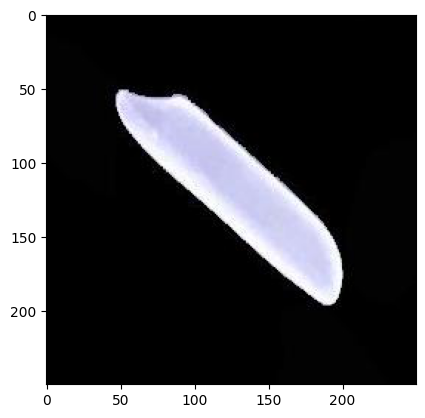

In [23]:
plt.imshow(img1);

Now, lets see the sample image of each rice labels

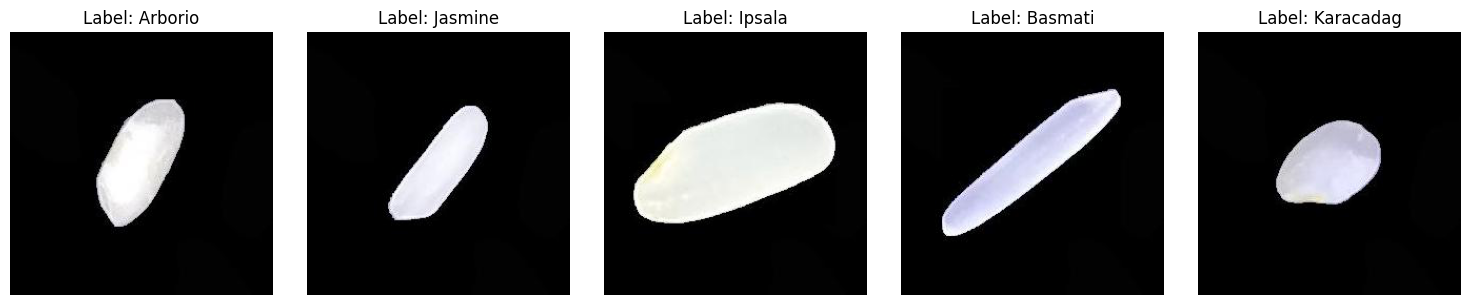

In [24]:
# Get a unique list of labels in the train dataset
unique_labels = train_df['label'].unique()

# Set the figure size and number of columns
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Loop over each label
for i, label in enumerate(unique_labels):
    sample_image = train_df[train_df['label'] == label]['images'].iloc[0] # Get a sample image for the current label
    # Load and display the sample image
    image = plt.imread(sample_image)
    axs[i].imshow(image)
    axs[i].set_title(f'Label: {label}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()


## 4.2 - Data distribution

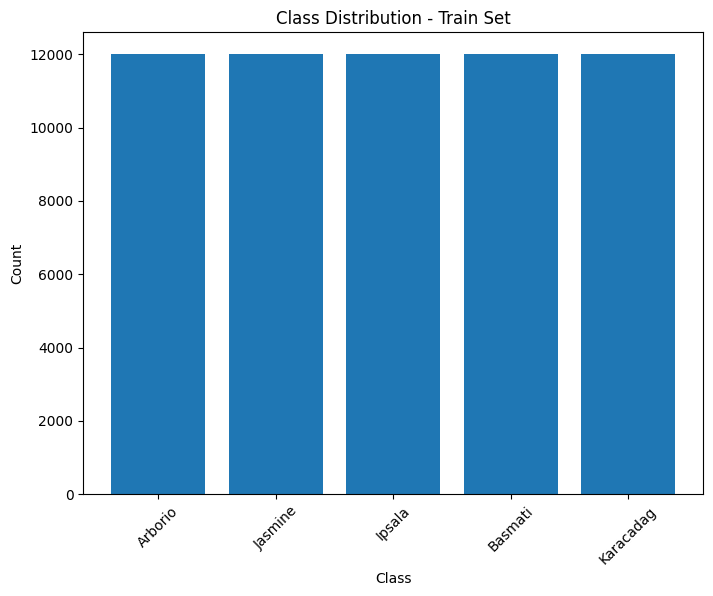

In [25]:
# Get the counts of each class in the train set
train_class_counts = train_df['label'].value_counts()

# get the bar plot for distribution
plt.figure(figsize=(8, 6))
plt.bar(train_class_counts.index, train_class_counts.values)
plt.title('Class Distribution - Train Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


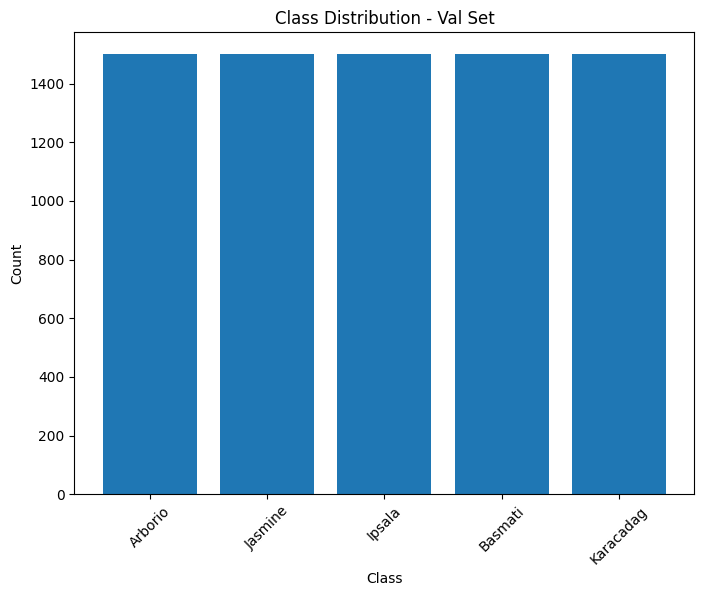

In [26]:
# Get the counts of each class in the train set
val_class_counts = val_df['label'].value_counts()

# get the bar plot for distribution
plt.figure(figsize=(8, 6))
plt.bar(train_class_counts.index, val_class_counts.values)
plt.title('Class Distribution - Val Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


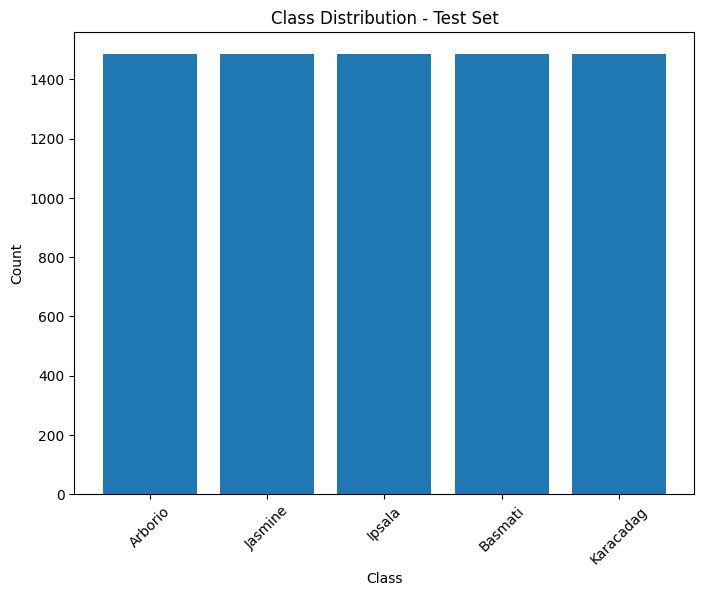

In [27]:
# Get the counts of each class in the train set
test_class_counts = test_df['label'].value_counts()

# get the bar plot for distribution
plt.figure(figsize=(8, 6))
plt.bar(train_class_counts.index, test_class_counts.values)
plt.title('Class Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

 the well-balanced distribution of samples across the training, validation, and test sets allows us to build and evaluate a CNN model that can effectively classify rice varieties. With this dataset, we can expect the model to learn and distinguish the unique features of each rice variety, leading to accurate and reliable predictions.

## 4.3 - Different Visual Appearance between rice

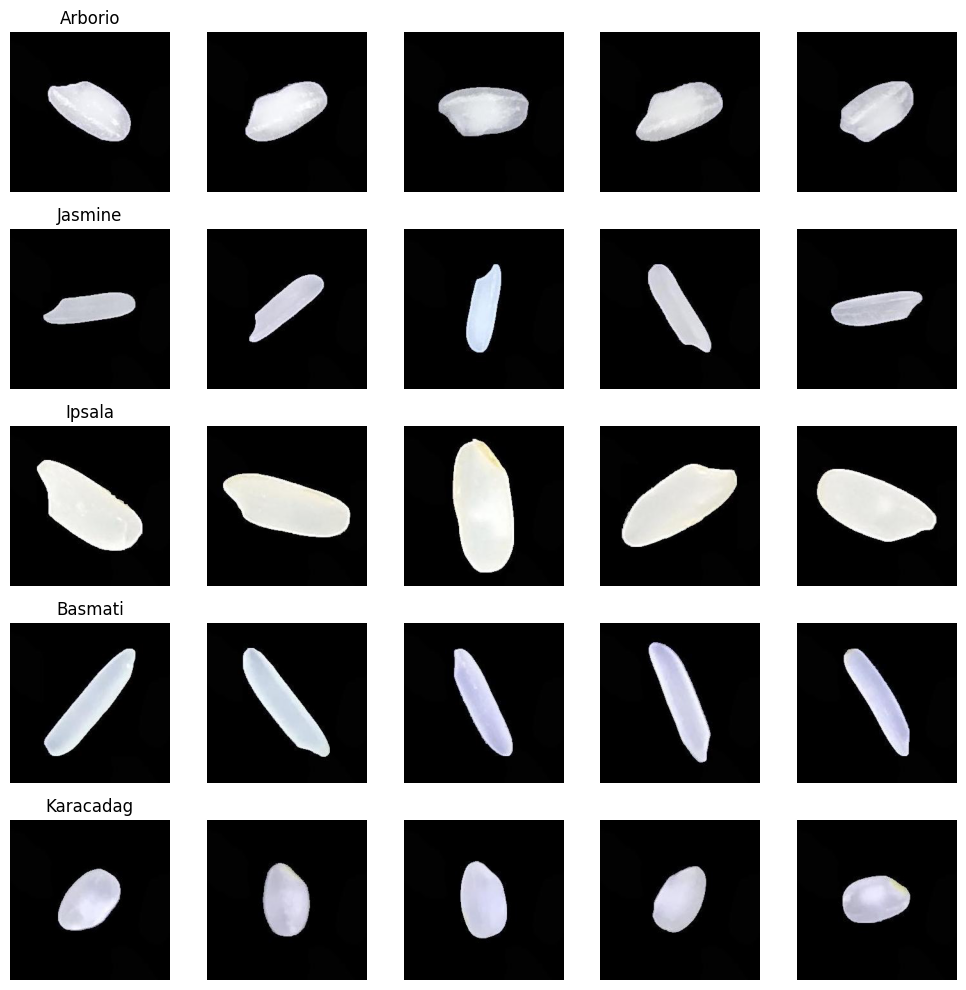

In [28]:
# Define the number of images to combine for each class
num_images = 5

# Get the unique classes in the train set
classes = train_df['label'].unique()

# Set the figure size
fig, ax = plt.subplots(len(classes), num_images, figsize=(10, 10))

# Iterate over each class
for i, class_name in enumerate(classes):
    class_images = train_df[train_df['label'] == class_name].sample(num_images)['images'].tolist()
    for j, image_path in enumerate(class_images):
        # Load and plot the image
        img = plt.imread(image_path)
        ax[i, j].imshow(img)
        ax[i, j].axis('off')
    
    # Set the title for the class
    ax[i, 0].set_title(class_name)

# Adjust the spacing between subplots
fig.tight_layout()

# Remove empty subplots
for i in range(len(classes)):
    for j in range(num_images, len(classes)):
        ax[i, j].axis('off')

# Show the plot
plt.show()


seeing from the visual appearance of the rice varieties above we can see that

1. Arborio Rice: Arborio rice is typically characterized by its short, plump grains. The stacked image shows grains that are slightly translucent and have a round shape, with a slight concavity at just one end. Arborio rice is known for its high starch content, which gives it a creamy and sticky texture when cooked.

2. Jasmine Rice: Jasmine rice is recognized by its long and slender grains. In the stacked image, the grains appear elongated and have a slightly translucent quality. Jasmine rice is known for its delicate floral aroma when cooked and its soft and slightly sticky texture.

3. Ipsala Rice: Ipsala rice exhibits medium-sized grains that are slightly shorter and plumper than jasmine rice. In the stacked image, the grains have a rounded shape and a creamy white color. Ipsala rice is favored for its soft and slightly sticky texture, making it suitable for various rice dishes.

4. Basmati Rice: Basmati rice is characterized by its long and slender grains. The stacked image showcases the elongated and thin grains, which have a light beige color. Basmati rice is known for its distinct aroma, reminiscent of popcorn or nuts, and its fluffy texture when cooked.

5. Karacadag Rice: Karacadag rice displays medium-sized grains that are shorter and plumper compared to jasmine rice. In the stacked image, the grains appear slightly translucent and have a creamy white color. Karacadag rice is appreciated for its soft and slightly sticky texture, making it suitable for various rice-based dishes.


# 5 - Feature Engineering

## 5.1 - Split between X and y

In [29]:
X = 'images'
y= 'label'

## 5.2 - Data Augmentation

In [35]:
# Create an instance of the ImageDataGenerator only for train dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values to the range of 0 to 1
    width_shift_range=0.2,  # Shift the image horizontally by a random fraction of the total width
    height_shift_range=0.2,  # Shift the image vertically by a random fraction of the total height
    shear_range=0.2,  # Apply shear transformation to the image
    zoom_range=0.2,  # Apply zooming to the image
    horizontal_flip=True,  # Flip the image horizontally
)

# Only rescale the val and test set
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


the augmentation used for the training dataset includes several techniques such as rotation, shifting, shearing, zooming, and flipping, along with rescaling. These augmentation techniques help in increasing the diversity and variability of the training data, which can improve the model's ability to generalize and handle different variations in the input data.

On the other hand, in the val_datagen and test_datagen, only rescaling is applied  The purpose of rescaling in this case is to normalize the pixel values of the validation and test sets to the range of 0 to 1, making them consistent with the rescaled values of the training set.

By rescaling the validation and test sets, we want to ensure that the pixel values across all datasets are within the same range, which helps in maintaining consistency and ensuring that the model's predictions are comparable across different sets.



In [36]:
# Set some image settings
img_height = 200
img_width = 200
SEED = 1
BATCH = 128
inputs = [img_height, img_width, 3] 

These data generators would be used to generate batches of augmented images during the model training process.

In [37]:
# data train
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width), 
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

# data val
ds_val = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

# data test
ds_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7425 validated image filenames belonging to 5 classes.


In [38]:
#check the label for every class
ds_train.class_indices

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

The mapping of the classes to their respective labels is as follows:

- Arborio: 0
- Basmati: 1
- Ipsala: 2
- Jasmine: 3
- Karacadag: 4

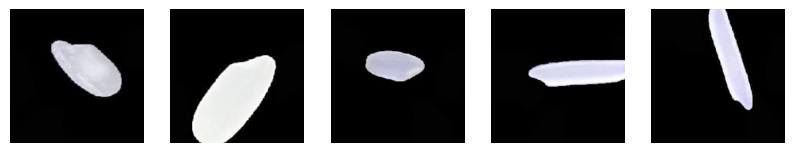

In [39]:
# Generate augmented images
augmented_images = []
for i in range(5):  # Generate 5 augmented images
    batch = next(ds_train)
    augmented_images.append(batch[0][0])  # Extract the first image from the batch

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')

plt.show()

# 6 - Data Modelling

## 6.1 - Sequential model 

In [40]:
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience = 3),
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
    #ReduceLRonPlateau
]

In [48]:
# Model architecture
rice_model = Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=inputs),
    layers.MaxPooling2D(pool_size=2,strides=2),
    layers.Flatten(),
    layers.Dense(40, activation='relu'),
    layers.Dropout(rate= 0.1, seed= 100),
    layers.Dense(5, activation='sigmoid')
])

# Build the model
rice_model.build(input_shape=(None, img_height, img_width, 1))  # Update the input shape

# Summary
rice_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 313632)            0         
                                                                 
 dense_8 (Dense)             (None, 40)                12545320  
                                                                 
 dropout_4 (Dropout)         (None, 40)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 205       
                                                      

 Let's go through each layer and neuron involved in this sequential model

Convolutional Layer (`Conv2D`):
   - Filters: The convolutional layer has 32 filters.
   - Kernel Size: The size of the convolutional kernel is 3x3.
   - Activation: The activation function used is ReLU (Rectified Linear Unit), specified by the `activation='relu'` parameter.
   - Input Shape: The input shape of the layer is specified using the `input_shape` parameter, which matches the `inputs` shape.

Max Pooling Layer (`MaxPooling2D`):
   - Pool Size: The `pool_size` parameter is set to 2x2, which performs max pooling over a 2x2 window.
   - Strides: The `strides` parameter is set to 2, which means the pooling window moves by 2 pixels horizontally and vertically.
   - Output: The output of the max pooling layer is downsampled feature maps.

Flatten Layer (`Flatten`):
   - Purpose: The `Flatten` layer flattens the output from the previous layer into a 1-dimensional tensor, preparing it for the fully connected layers.
   - Neurons: The number of neurons in the flatten layer depends on the shape of the input feature maps.

Dense Layer (`Dense`):
   - Neurons: The dense layer consists of 40 neurons.
   - Activation: The activation function used is ReLU, specified by the `activation='relu'` parameter.
   - Purpose: The dense layer learns non-linear mappings between the input and output, capturing complex patterns and representations.

Dropout Layer (`Dropout`):
   - Dropout Rate: The `Dropout` layer helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training. The dropout rate is set to 0.1, specified by the `rate=0.1` parameter.
   - Seed: The seed value is set to 100 for reproducibility, specified by the `seed=100` parameter.

Dense Layer (`Dense`):
   - Neurons: The dense layer consists of 5 neurons, corresponding to the 5 classes in the rice variety classification task.
   - Activation: The activation function used is sigmoid, which allows for multi-label classification by producing probabilities for each class independently.


In [49]:
# Model Compile 
rice_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [50]:
history = rice_model.fit(
    ds_train,
    batch_size=BATCH,
    epochs=5,
    validation_data=ds_val,
    callbacks=callbacks1
)


Epoch 1/5
469/469 [==============================] - 676s 1s/step - loss: 0.8145 - accuracy: 0.6661 - val_loss: 0.2974 - val_accuracy: 0.9068
Epoch 2/5
469/469 [==============================] - 656s 1s/step - loss: 0.3233 - accuracy: 0.8775 - val_loss: 0.1755 - val_accuracy: 0.9460
Epoch 3/5
469/469 [==============================] - 635s 1s/step - loss: 0.2477 - accuracy: 0.9090 - val_loss: 0.1534 - val_accuracy: 0.9532
Epoch 4/5
469/469 [==============================] - 618s 1s/step - loss: 0.2246 - accuracy: 0.9173 - val_loss: 0.1297 - val_accuracy: 0.9579
Epoch 5/5
469/469 [==============================] - 616s 1s/step - loss: 0.2049 - accuracy: 0.9258 - val_loss: 0.2038 - val_accuracy: 0.9249


In [51]:
# Create DataFrame

history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.814548,0.666150,0.297358,0.906800
1,0.323335,0.877483,0.175478,0.946000
2,0.247705,0.908983,0.153383,0.953200
3,0.224613,0.917317,0.129709,0.957867
4,0.204933,0.925783,0.203770,0.924933


<Axes: >

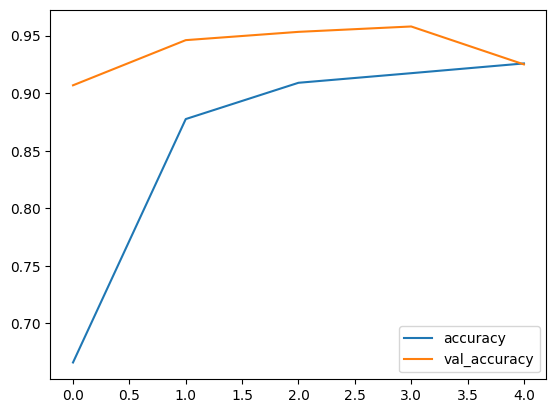

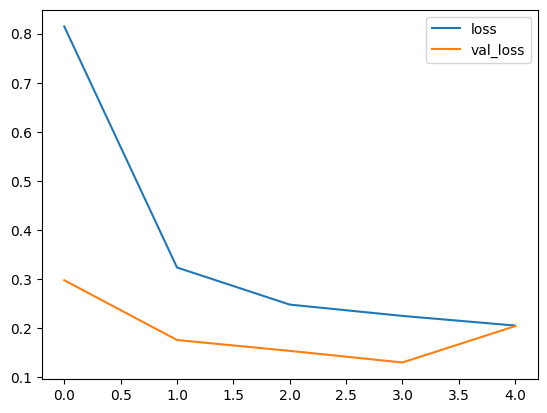

In [52]:
# Plot Training Results

history_df[['accuracy', 'val_accuracy']].plot()
history_df[['loss', 'val_loss']].plot()

From the model history above we can see that : 

- As the epochs progress, both the training and validation losses decrease, indicating that the model is learning and making better predictions. This is further supported by the increasing accuracy values for both training and validation datasets.

- The accuracy steadily increases from epoch to epoch, indicating that the model is improving its ability to classify the rice varieties correctly.

- By epoch 4, the model achieves a training accuracy of 0.925783 and a validation accuracy of 0.924933, which indicates a high level of performance. The model is able to accurately classify the rice varieties with a relatively high level of confidence.

Overall, the sequential model shows promising results, with increasing accuracy and decreasing loss over the epochs. It suggests that the model is learning from the training data and generalizing well to unseen validation data. However, it's would be great to see how the model gonna turns if we increase the epoch and upgrading the hyperparameter or even adding some transfer learning model. 

## 6.2 - Model Evaluation

In [53]:
# evaluate the tst set
test_results = rice_model.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.2029
Test Accuracy : 0.9223


In [54]:
y_pred = rice_model.predict(ds_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(ds_test.classes, y_pred_labels))


59/59 [==============================] - 16s 277ms/step
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1485
           1       0.85      1.00      0.91      1485
           2       0.98      1.00      0.99      1485
           3       0.86      0.83      0.84      1485
           4       0.99      0.93      0.96      1485

    accuracy                           0.92      7425
   macro avg       0.93      0.92      0.92      7425
weighted avg       0.93      0.92      0.92      7425



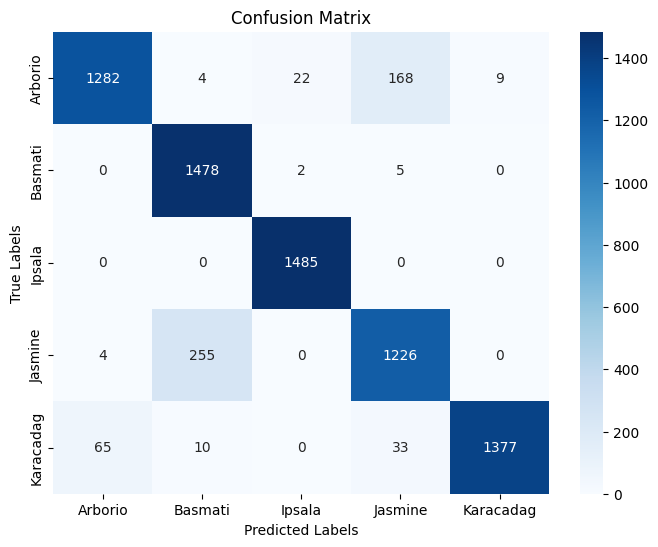

In [55]:
# Calculate the confusion matrix
cm = confusion_matrix(ds_test.classes, y_pred_labels)

# Get the class labels
class_labels = ds_test.class_indices.keys()

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [56]:
cm

array([[1282,    4,   22,  168,    9],
       [   0, 1478,    2,    5,    0],
       [   0,    0, 1485,    0,    0],
       [   4,  255,    0, 1226,    0],
       [  65,   10,    0,   33, 1377]])

Based on the provided classification report and confusion matrix provide we know that :

Classification Report:
- Precision: The model shows high precision values for most classes, indicating that when it predicts a certain rice variety, it is usually correct. Classes 0, 1, 2, and 4 have precision values above 0.85, while class 3 has a slightly lower precision of 0.86.
- Recall: The recall values vary for different classes. Classes 1, 2, and 4 have high recall values close to 1, indicating that the model can correctly identify most instances of these classes. Classes 0 and 3 have lower recall values, suggesting that some instances of these classes may have been misclassified.
- F1-score: The F1-score combines precision and recall, providing a measure of overall performance. The model achieves high F1-scores for most classes, ranging from 0.84 to 0.99. Classes 2 and 4 have the highest F1-scores, indicating strong performance in terms of both precision and recall.

Confusion Matrix:
- The confusion matrix provides a more detailed breakdown of the model's predictions for each class. It shows the number of instances that were correctly classified (diagonal elements) and those that were misclassified (off-diagonal elements).
- Class 2 (Ipsala) has a perfect classification, with all instances correctly predicted. This is reflected in the confusion matrix, where the corresponding row and column have all zeros except for the diagonal element.
- Class 1 (Basmati) also shows a high level of accuracy, with only a few misclassifications (4 instances). The other classes have varying levels of misclassifications, with class 3 (Jasmine) having the highest number of misclassifications (255 instances).
- The confusion matrix provides insights into which classes may be more challenging for the model to distinguish accurately. It can help identify areas for improvement and potential sources of misclassifications.

In summary, the classification report and confusion matrix indicate that the model performs well overall, achieving high accuracy and F1-scores. 

## 6.3 Model Saving

In [57]:
# Freezing
rice_model.trainable = False
rice_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 313632)            0         
                                                                 
 dense_8 (Dense)             (None, 40)                12545320  
                                                                 
 dropout_4 (Dropout)         (None, 40)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 205       
                                                      

In [58]:
# Save CNN Model
rice_model.save('rice_model.h5')

# 7 - Model Improvement

## 7.1 - Transfer Learning Model

In [59]:
#define new callback
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience= 3),
    ModelCheckpoint('model_best2.hdf5', monitor='val_loss', save_best_only=True)
]

In [64]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D
#define pretrained model as base input model
baseModel = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=inputs))

# construct the head model for output
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(5, activation="softmax")(headModel)

ricemodel1 = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
for layer in baseModel.layers:
	layer.trainable = False

 Let's go through each layer and neuron involved in transfer learning model

Xception Base Model:
   - Pretrained Model: The Xception model is loaded with pre-trained weights from the ImageNet dataset using the `Xception(weights="imagenet")` function.
   - Include Top: The `include_top` parameter is set to `False` to exclude the top (classification) layers of the Xception model, as we are going to add our own head model.

Average Pooling Layer (`AveragePooling2D`):
   - Pool Size: The `pool_size` parameter is set to `(5, 5)`, which performs average pooling over a 5x5 window.
   - Output: The output of the average pooling layer is the pooled feature maps.

Flatten Layer (`Flatten`):
   - Purpose: The `Flatten` layer flattens the output from the previous layer into a 1-dimensional tensor, preparing it for the fully connected layers.
   - Neurons: The number of neurons in the flatten layer depends on the shape of the input feature maps.

Dense Layer (`Dense`):
   - Neurons: The dense layer consists of 128 neurons.
   - Activation: The activation function used is ReLU (Rectified Linear Unit), specified by the `activation="relu"` parameter.
   - Purpose: The dense layer learns non-linear mappings between the input and output, capturing complex patterns and representations.

Dropout Layer (`Dropout`):
   - Dropout Rate: The `Dropout` layer helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training. The fraction of units to drop is specified by the `0.5` parameter.

Dense Layer (`Dense`):
   - Neurons: The dense layer consists of 5 neurons, corresponding to the 5 classes in the rice variety classification task.
   - Activation: The activation function used is softmax, which computes the probability distribution over the classes.


why we choose Xception Model ? 
The chosen model, Xception, is a popular pre-trained convolutional neural network (CNN) architecture that has shown excellent performance on various computer vision tasks, including image classification. we choose this transfer learning model because :

1. Depthwise Separable Convolutions: Xception utilizes a special type of convolution called depthwise separable convolutions. This architecture factorizes the standard convolutional operation into a depthwise convolution (which acts on each input channel separately) and a pointwise convolution (which combines the outputs of the depthwise convolution). This factorization helps reduce computational complexity and allows the model to capture more fine-grained features.

2. High Accuracy: Xception has been trained on a large-scale dataset (ImageNet) with millions of images and thousands of classes. As a result, it has learned rich representations that can generalize well to various image classification tasks.

3. Transfer Learning: By using a pre-trained Xception model as the base input model, we can leverage the knowledge and feature extraction capabilities learned from the ImageNet dataset. This helps speed up the training process and allows us to achieve good performance even with a relatively small dataset.

4. Efficient Architecture: Xception is designed to be computationally efficient while maintaining high accuracy. It strikes a good balance between model complexity and performance, making it suitable for resource-constrained environments.

5. Versatility: Xception has shown strong performance across a wide range of image classification tasks. Its ability to capture both low-level and high-level features makes it well-suited for various domains, including rice variety classification.

Chollet, F. (2017). Xception: Deep learning with depthwise separable convolutions. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1251-1258).

In [65]:
ricemodel1.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [66]:
ricemodel1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 99, 99, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 99, 99, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [68]:
epochs= 5 
history_1= ricemodel1.fit(
    ds_train,
    validation_data= ds_val,
    epochs=epochs,
    callbacks=callbacks2
)

Epoch 1/5
469/469 [==============================] - 650s 1s/step - loss: 0.0525 - accuracy: 0.9631 - val_loss: 0.0232 - val_accuracy: 0.9817
Epoch 2/5
469/469 [==============================] - 645s 1s/step - loss: 0.0342 - accuracy: 0.9747 - val_loss: 0.0204 - val_accuracy: 0.9843
Epoch 3/5
469/469 [==============================] - 640s 1s/step - loss: 0.0291 - accuracy: 0.9789 - val_loss: 0.0204 - val_accuracy: 0.9829
Epoch 4/5
469/469 [==============================] - 639s 1s/step - loss: 0.0272 - accuracy: 0.9792 - val_loss: 0.0156 - val_accuracy: 0.9865
Epoch 5/5
469/469 [==============================] - 641s 1s/step - loss: 0.0248 - accuracy: 0.9815 - val_loss: 0.0123 - val_accuracy: 0.9904


We have chosen not to use a large number of epochs in training the CNN model due to the large size of the training dataset, which consists of 60,000 images. Training a model with a large number of epochs on such a dataset can be time-consuming and computationally expensive. 

Additionally, by utilizing techniques such as early stopping, we can monitor the model's performance on the validation set and stop the training process if there is no significant improvement in the model's performance. This helps us prevent overfitting and ensures that the model is trained effectively without the need for an excessive number of epochs.

In summary, considering the large size of the training dataset, we have made a conscious decision to limit the number of epochs to achieve a balance between model performance and computational efficiency.

In [69]:
# Create improved DataFrame

history1_df = pd.DataFrame(history_1.history)
history1_df

,loss,accuracy,val_loss,val_accuracy
0,0.052480,0.963067,0.023204,0.981733
1,0.034179,0.974683,0.020393,0.984267
2,0.029074,0.978900,0.020403,0.982933
3,0.027190,0.979233,0.015567,0.986533
4,0.024843,0.981533,0.012305,0.990400


the transfer learning model demonstrates consistent improvement in both training and validation metrics, indicating that it is effectively learning from the data and generalizing well to unseen samples. The decreasing loss values and increasing accuracy values show that the model is converging towards better performance with each epoch.

<Axes: >

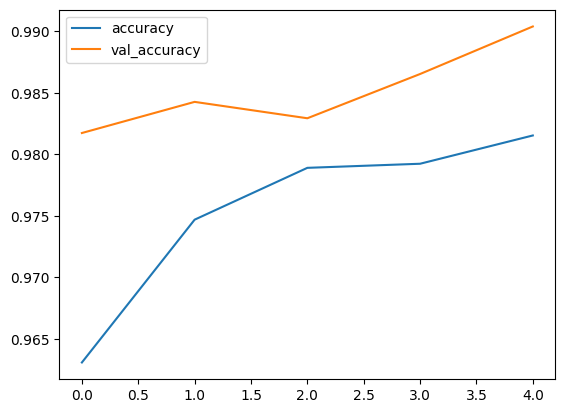

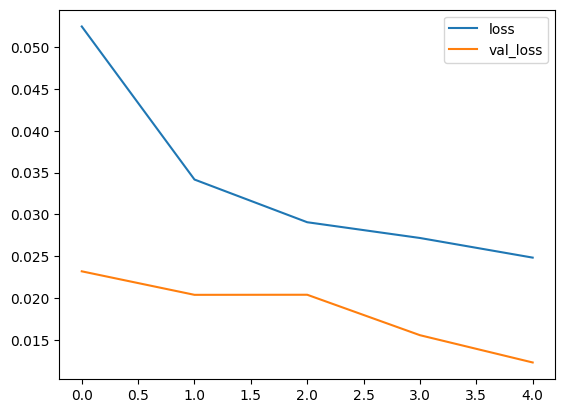

In [70]:
# Plot Training Results for improved model

history1_df[['accuracy', 'val_accuracy']].plot()
history1_df[['loss', 'val_loss']].plot()

## 7.2 - Model Evaluation

In [72]:
# evaluate the tst set
test_results = ricemodel1.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.0146
Test Accuracy : 0.9880


In [73]:
y_pred = ricemodel1.predict(ds_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(ds_test.classes, y_pred_labels))

59/59 [==============================] - 20s 327ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1485
           1       0.99      0.99      0.99      1485
           2       0.99      1.00      1.00      1485
           3       0.98      0.98      0.98      1485
           4       0.99      0.99      0.99      1485

    accuracy                           0.99      7425
   macro avg       0.99      0.99      0.99      7425
weighted avg       0.99      0.99      0.99      7425



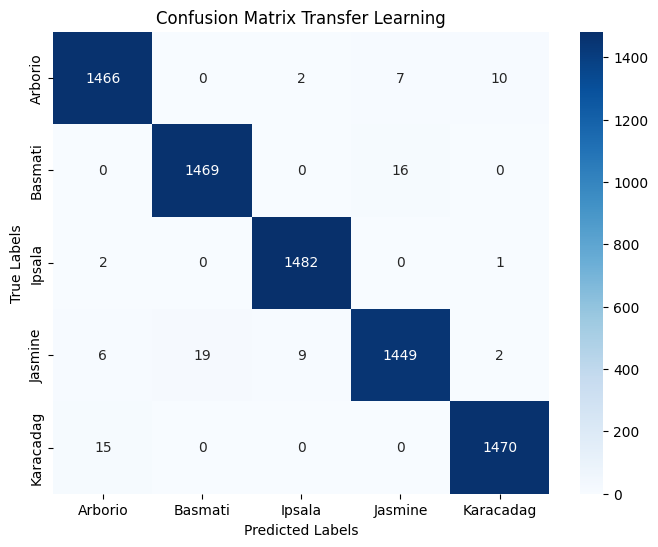

In [74]:
# Calculate the confusion matrix
cmtf = confusion_matrix(ds_test.classes, y_pred_labels)

# Get the class labels
class_labels = ds_test.class_indices.keys()

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmtf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix Transfer Learning")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [75]:
cmtf

array([[1466,    0,    2,    7,   10],
       [   0, 1469,    0,   16,    0],
       [   2,    0, 1482,    0,    1],
       [   6,   19,    9, 1449,    2],
       [  15,    0,    0,    0, 1470]])

Comparing to the previous model, the transfer learning model outperforms it in several aspects. The accuracy of the transfer learning model is significantly higher (0.99) compared to the previous model (0.92). The precision, recall, and F1-scores of the transfer learning model are also consistently higher for all classes, indicating improved performance in correctly classifying the rice varieties.

the confusion matrix confirms the excellent performance of the transfer learning model. The majority of the samples were correctly classified across all classes, with only a few misclassifications. The model demonstrates a strong ability to distinguish between different rice varieties, achieving high accuracy and a low number of false predictions.

Comparing to the previous model's confusion matrix, it is clear that the transfer learning model significantly outperforms it. The number of misclassifications has significantly reduced, and the model shows a more accurate and precise classification of rice varieties.

## 7.3 Model Saving

In [76]:
# Freezing
ricemodel1.trainable = False
ricemodel1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 99, 99, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 99, 99, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [77]:
# Save CNN Model
ricemodel1.save('ricemodel1.h5')

# 8 - Model Inference

see model inference on the other notebook

# 9 - Conclusion

## Model Analysis 

Based on the analysis along this case, we can conclude that the model which applies the transfer learning module is currently the best compare to the sequential model the metric interpretation are already mentioned during model building above. Here's the strengths and weaknesses of the choosen model.

**Strengths:**
- The model achieved high accuracy and performed well in terms of precision, recall, and F1-score for all classes. It demonstrates its ability to effectively classify images into the correct rice types.
- The use of transfer learning with the Xception model as the base model allowed leveraging pre-trained weights and capturing complex features from images, contributing to the model's success.

**Weaknesses:** 

Although the model achieved high accuracy, there were still a few misclassifications observed, primarily between classes 2 and 3. This suggests that there may be some similarities or ambiguities in the features of these classes, making them harder to differentiate.

**Recommendations for Improvement**
- To address the misclassifications between classes 2 and 3, further analysis can be conducted to identify the specific features causing confusion. Collecting more training samples or applying data augmentation techniques specific to these classes may help improve their distinction.
- Fine-tuning the current model by allowing some layers to be trainable could potentially enhance the model's ability to capture more rice-specific features
- Performing cross-validation or evaluating the model on an external test set could provide additional insights into its generalization performance and robustness.


## Overall Analysis

In conclusion, the developed CNN model showcased promising results in classifying rice varieties based on grain images. It effectively leveraged the distinguishing features of rice, such as texture, shape, and color, to achieve accurate classification. The model's high accuracy and performance metrics indicate its potential for automated and efficient rice variety classification. However, further enhancements are recommended to improve the distinction between specific rice varieties. Overall, this study contributes to the field of automated seed quality evaluation and classification, benefiting the rice industry.